# Compare RAGIS ice-sheet wide timeseries to IMBIE

In [1]:
from datetime import datetime
import numpy as np
import pylab as plt
import xarray as xr
from glob import glob
import pandas as pd
import os
from pismragis.observations import load_imbie
from pismragis.processing import convert_netcdf_to_dataframe
from pismragis.sensitivity import sensitivity_analysis

## Load IMBIE

In [2]:
imbie = load_imbie()

glob PISM scalar time series files

In [55]:
data_dir = "../hindcasts"
proj_dir = "2023_04_ocean_simple"

scalar_dir = "processed"
lhs = "gris_ragis_ocean_simple_lhs_50_w_posterior.csv"

proj_dir = "2023_04_ocean_simple_20"
scalar_dir = "scalar"
lhs = "gris_ragis_ocean_simple_lhs_20.csv"


ens_file = os.path.join(data_dir, proj_dir, "uq", lhs)
scalar_files = sorted(glob(os.path.join(data_dir, proj_dir, scalar_dir, "ts_gris_g*00m_v20*RAGIS_id_*_1980-1-1_2020-1-1.nc")))

In [56]:
df = convert_netcdf_to_dataframe(scalar_files, resample="yearly")

Processing files: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.53it/s]

Program finished in 2 seconds


In [57]:
sa_df = sensitivity_analysis(df, ensemble_file=ens_file)

Processing file: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:04<00:00,  9.33it/s]


In [58]:
df.columns

Index(['time', 'id', 'basal_mass_flux_floating (Gt year-1)',
       'basal_mass_flux_grounded (Gt year-1)', 'dt (year)',
       'grounding_line_flux (Gt year-1)', 'ice_area_glacierized (m2)',
       'ice_area_glacierized_cold_base (m2)',
       'ice_area_glacierized_floating (m2)',
       'ice_area_glacierized_grounded (m2)',
       'ice_area_glacierized_temperate_base (m2)', 'ice_enthalpy (J)',
       'ice_enthalpy_glacierized (J)', 'ice_mass (kg)',
       'ice_mass_glacierized (kg)', 'ice_volume (m3)', 'ice_volume_cold (m3)',
       'ice_volume_glacierized (m3)', 'ice_volume_glacierized_cold (m3)',
       'ice_volume_glacierized_floating (m3)',
       'ice_volume_glacierized_grounded (m3)',
       'ice_volume_glacierized_temperate (m3)', 'ice_volume_temperate (m3)',
       'limnsw (kg)', 'liquified_ice_flux (m3 / year)',
       'max_diffusivity (m2 s-1)', 'max_sliding_vel (m year-1)',
       'sea_level_rise_potential (m)', 'surface_accumulation_rate (kg year-1)',
       'surface_melt

## Plot

Plot time series of cumulative mass change (cm SLE) and discharge at grounding line (Gt/yr)

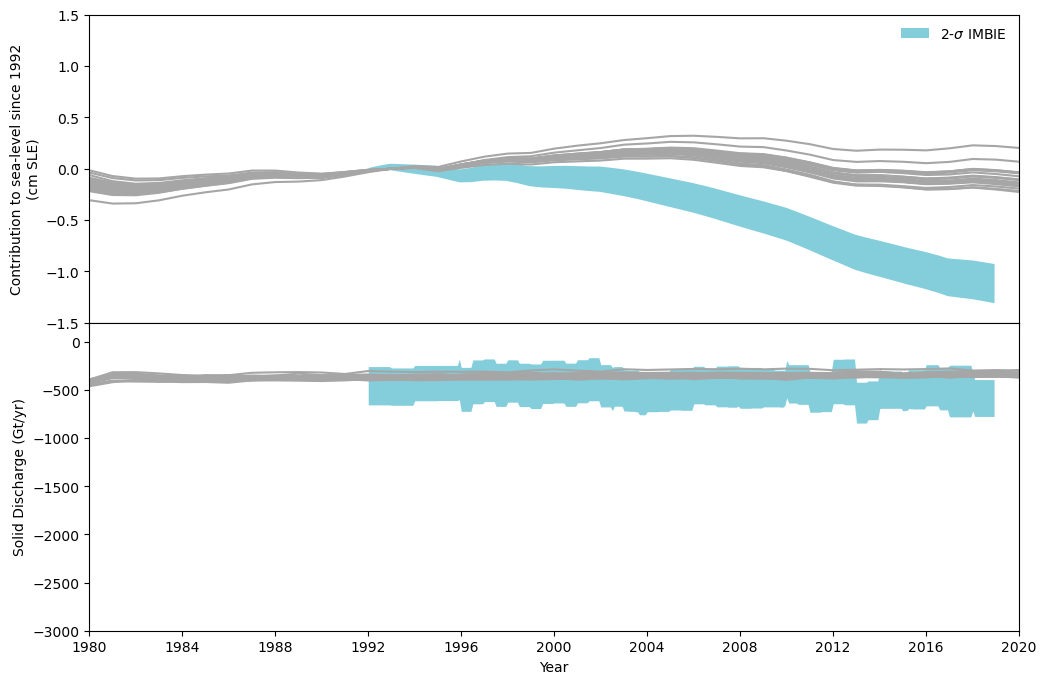

In [59]:
mass_varname = "limnsw"
flux_varname = "grounding_line_flux"
bg_color = "#216779"
bg_color = "w"

sim_color = "#882255"
imbie_color = "#84cedb"


def normalize_by_date(ds, varname="limnsw", date="1992-1-1"):
    return ds[varname] - ds.sel(time="1992-1-1", method="nearest")[varname]
    
kg2cmsle = 1 / 1e12 * 1.0 / 362.5 / 10.0
gt2cmsle = 1 / 362.5 / 10.0
sigma = 2
plt.style.use('default')

fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(12, 8))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

for id, ens in df.groupby(by="id"):
    if len(ens) > 13:
        axs[0].plot(ens["time"], (ens["limnsw (kg)"] - ens["limnsw (kg)"][13]) * kg2cmsle, color="0.65" )
        axs[1].plot(ens["time"], (ens["grounding_line_flux (Gt year-1)"]), color="0.65" )


    
axs[0].fill_between(imbie["Date"], 
                    (imbie["Mass (Gt)"] + sigma * imbie["Mass uncertainty (Gt)"]) * gt2cmsle, 
                    (imbie["Mass (Gt)"] - sigma * imbie["Mass uncertainty (Gt)"]) / 362.5 / 10.0, 
                    ls="solid", lw=0, alpha=1, color=imbie_color, label="2-$\sigma$ IMBIE")
axs[1].fill_between(imbie["Date"], 
                    (imbie["D (Gt/yr)"] + sigma * imbie["D uncertainty (Gt/yr)"]), 
                    (imbie["D (Gt/yr)"] - sigma * imbie["D uncertainty (Gt/yr)"]), 
                    ls="solid", lw=0, alpha=1, color=imbie_color)



fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)

    
axs[0].set_xlabel("")
axs[0].set_ylabel("Contribution to sea-level since 1992\n(cm SLE)")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Solid Discharge (Gt/yr)")
axs[0].set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2020-1-1"))
axs[0].set_ylim(-1.5, 1.5)
axs[1].set_ylim(-3000, 200)
legend = axs[0].legend()
legend.get_frame().set_linewidth(0.0)
legend.get_frame().set_alpha(0.0)
fig.savefig(f"ragis-{lhs}_scalar.pdf")


In [52]:
def resample_ensemble_by_data(
    observed,
    simulated,
    calibration_start=1992,
    calibration_end=2017,
    fudge_factor=3,
    n_samples=100,
    verbose=False,
    m_var="Mass (Gt)",
    m_var_std="Mass uncertainty (Gt)",
):
    """
    Resampling algorithm by Douglas C. Brinkerhoff


    Parameters
    ----------
    observed : pandas.DataFrame
        A dataframe with observations
    simulated : pandas.DataFrame
        A dataframe with simulations
    calibration_start : float
        Start year for calibration
    calibration_end : float
        End year for calibration
    fudge_factor : float
        Tolerance for simulations. Calculated as fudge_factor * standard deviation of observed
    n_samples : int
        Number of samples to draw.

    """

    observed_calib_time = (observed["Year"] >= calibration_start) & (
        observed["Year"] <= calibration_end
    )
    observed_calib_period = observed[observed_calib_time]
    observed_interp_mean = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var]
    )
    observed_interp_std = interp1d(
        observed_calib_period["Year"], observed_calib_period[m_var_std]
    )
    simulated_calib_time = (simulated["Year"] >= calibration_start) & (
        simulated["Year"] <= calibration_end
    )
    simulated_calib_period = simulated[simulated_calib_time]

    resampled_list = []
    log_likes = []
    experiments = sorted(simulated_calib_period["Experiment"].unique())
    evals = []
    for i in experiments:
        exp_ = simulated_calib_period[
            (simulated_calib_period["Experiment"] == i)
        ]
        exp_interp = interp1d(exp_["Year"], exp_[m_var])
        log_like = 0.0
        for year, observed_mean, observed_std in zip(observed_calib_period["Year"], 
                                                     observed_calib_period[m_var], 
                                                     observed_calib_period[m_var_std]):
            try:
                observed_std *= fudge_factor
                exp = exp_interp(year)

                log_like -= 0.5 * (
                    (exp - observed_mean) / observed_std
                ) ** 2 + 0.5 * np.log(2 * np.pi * observed_std**2)
                # print(i, year, f"{observed_mean:.3f}", f"{exp:.3f}")
            except ValueError:
                pass
        if log_like != 0:
            evals.append(i)
            log_likes.append(log_like)
            if verbose:
                print(f"Experiment {i:.0f}: {log_like:.2f}")
    experiments = np.array(evals)
    w = np.array(log_likes)
    w -= w.mean()
    weights = np.exp(w)
    weights /= weights.sum()
    resampled_experiments = np.random.choice(experiments, n_samples, p=weights)
    new_frame = []
    for i in resampled_experiments:
        new_frame.append(
            simulated[(simulated["Experiment"] == i)]
        )
    simulated_resampled = pd.concat(new_frame)
    resampled_list.append(simulated_resampled)

    simulated_resampled = pd.concat(resampled_list)

    return simulated_resampled



In [53]:
ragis_calib = resample_ensemble_by_data(imbie, data_df, 
                                        fudge_factor=5)
calib_exps = ragis_calib["Experiment"].unique()
print(calib_exps)

NameError: name 'data_df' is not defined

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex="col", figsize=(12, 8))
fig.subplots_adjust(wspace=0.0, hspace=0.0)

q_5 = ragis_calib.groupby(by="Year").quantile(0.05)
q_16 = ragis_calib.groupby(by="Year").quantile(0.16)
q_50 = ragis_calib.groupby(by="Year").quantile(0.50)
q_84 = ragis_calib.groupby(by="Year").quantile(0.84)
q_95 = ragis_calib.groupby(by="Year").quantile(0.95)
for exp in calib_exps:
    e = data_df[data_df["Experiment"] == exp]
    axs[0].plot(e["Year"], e["Mass (Gt)"])
    axs[1].plot(e["Year"], e["D (Gt/yr)"])

# axs[0].fill_between(q_50.index, q_16["Mass (Gt)"], q_84["Mass (Gt)"], color="w")
axs[0].fill_between(imbie["Year"], 
                    (imbie["Mass (Gt)"] + sigma * imbie["Mass uncertainty (Gt)"]), 
                    (imbie["Mass (Gt)"] - sigma * imbie["Mass uncertainty (Gt)"]), 
                    ls="solid", lw=0, alpha=0.5, color="#6baed6", label="2-$\sigma$ IMBIE")
axs[1].fill_between(imbie["Year"], 
                    (imbie["D (Gt/yr)"] + sigma * imbie["D uncertainty (Gt/yr)"]), 
                    (imbie["D (Gt/yr)"] - sigma * imbie["D uncertainty (Gt/yr)"]), 
                    ls="solid", lw=0, alpha=1, color=imbie_color)


axs[0].set_xlim(1992, 2017)
fig.set_facecolor(bg_color)
for ax in axs:
    ax.set_facecolor(bg_color)
fig.set_facecolor(bg_color)




In [ ]:
ensemble_file = "data/pism/2023_04_ocean_simple/uq/ensemble_gris_ragis_ocean_simple_lhs_50_w_posterior.csv"

In [ ]:
def compute_indices(df, 
                    ensemble_file=None,
                    calc_variable="grounding_line_flux (Gt year-1)",
                   ):
    
    # remove True/False
    id_df = (pd.read_csv(ensemble_file) * 1).replace(np.nan, 0)

    param_names = id_df.drop(columns="id").columns.values.tolist()
    for k, col in id_df.items():
        if is_string_dtype(col):
            u = col.unique()
            u.sort()
            v = [k for k, v in enumerate(u)]
            col.replace(to_replace=dict(zip(u, v)), inplace=True)
    # Define a salib "problem"
    problem = {
        "num_vars": len(id_df.drop(columns="id").columns.values),
        "names": param_names,  # Parameter names
        "bounds": zip(
            id_df.drop(columns="id").min().values,
            id_df.drop(columns="id").max().values,
        ),  # Parameter bounds
    }
    stats_dfs = []
    
    
    for m_date, s_df in df.groupby(by="time"):
        print(f"Processing {m_date}")
        k = 0
        try:
            response_matrix = s_df[calc_variable].values
            Si = delta.analyze(
                problem,
                id_df.drop(columns="id").values,
                response_matrix,
                num_resamples=100,
                print_to_console=False,
            )
            Si_df = Si.to_df()
            print(Si_df)
            indices = ["delta", "S1"]

            s_dfs = []
            for s_index in indices:
                m_df = pd.DataFrame(
                    data=Si_df[s_index].values.reshape(1, -1),
                    columns=Si_df.transpose().columns,
                )
                m_df["Date"] = m_date
                m_df.set_index("Date")
                m_df["Si"] = s_index
                
                m_conf_df = pd.DataFrame(
                    data=Si_df[s_index + "_conf"].values.reshape(1, -1),
                    columns=Si_df.transpose().columns,
                )
                m_conf_df["Date"] = m_date
                m_conf_df.set_index("Date")
                m_conf_df["Si"] = s_index + "_conf"
                merged_df = pd.concat([m_df, m_conf_df])
                s_dfs.append(merged_df)
            s_df = pd.concat(s_dfs)
            stats_dfs.append(s_df)

        except:
            pass
    stats_df = pd.concat(stats_dfs)
    stats_df.reset_index(inplace=True, drop=True)
    stats_df.set_index(stats_df["Date"], inplace=True)
    return stats_df


In [ ]:
def load_scalar_ts(infiles):
    dfs = []
    for infile in infiles:
        print(f"Processing {infile}")
        if os.path.isfile(infile):
            ds = xr.open_dataset(infile)
            m_id = int(re.search("id_(.+?)_", infile).group(1))
            m_dx = int(re.search("gris_g(.+?)m", infile).group(1))
            S = []
            for m_var in ds.data_vars:
                if m_var not in ("time_bounds", "time_bnds", "timestamp", "pism_config", "run_stats"):
                    if hasattr(ds[m_var], "units"):
                        m_units = ds[m_var].units
                    else:
                        m_units = ""
                    m_S_name = f"{m_var} ({m_units})"
                    m_S = ds[m_var].to_dataframe(name=m_S_name)

                    S.append(m_S)
        df = pd.concat(S, axis=1).reset_index()
        df["id"] = m_id
        dfs.append(df)
    return pd.concat(dfs).reset_index()


In [ ]:
processed_dir = "scalar"
indices_files = sorted(glob(os.path.join(data_dir, proj_dir, processed_dir, "ts_gris_g*00m_v20*_RAGIS_id_*_1980-1-1_2020-1-1.nc")))
indices_df = load_scalar_ts(indices_files)

In [ ]:
#limnsw_df = compute_indices(indices_df, ensemble_file=ensemble_file, calc_variable="limnsw (kg)")
d_df = compute_indices(indices_df, ensemble_file=ensemble_file, calc_variable="grounding_line_flux (Gt year-1)")

In [ ]:
plt.style.use('default')
plt.style.use('seaborn-v0_8-colorblind')
indices=["S1", "delta"]

for m_var in stats_df["Variable"].unique():
    df = stats_df[stats_df["Variable"] == m_var].drop(columns=["Variable"])
    fig, axs = plt.subplots(
        len(indices),
        1,
        sharex="col",
        figsize=[12, 10],
    )
    for k, si in enumerate(indices):
        ax = axs[k]
        p_df = (
            df[df["Si"] == si]
            .drop(columns=["Date", "Si"])
        )

        p_conf_df = (
            df[df["Si"] == si + "_conf"]
            .drop(columns=["Date", "Si"])
        )

        [ax.errorbar(p_df.index, p_df[v], yerr=p_conf_df[v], lw=2, label=v) for v in p_df.keys()]

        axs[k].set_title(f"{si} indices for {m_var}")
    legend = axs[0].legend(loc="upper right", ncol=4)
    fig.savefig(f"{m_var}_indices.pdf")


In [ ]:
category_dict = {
    "Climate": {"color": "#81c77f", "vars": []},
    "Surface": {"color": "#886c62"},
    "Ocean": {"color": "#beaed4"},
    "Ice Dynamics": {"color": "#dcd588"},
}


In [ ]:
for si in ["delta", "S1"]:

    fig, axs = plt.subplots(
        2,
        1,
        sharex="col",
        figsize=[12, 10],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["limnsw (kg)", "grounding_line_flux (Gt year-1)"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        ax = axs.ravel()[k]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=2.5, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        [
            ax.fill_between(
                p_df.index,
                p_df[v].values - p_conf_df[v].values,
                p_df[v].values + p_conf_df[v].values,
                alpha=0.2,
                lw=0,
            )
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]
        ax.set_xlim(datetime(1980, 1, 1), datetime(2020, 1, 1))
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = axs[-1].legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.35))
    fig.tight_layout()
    fig.savefig(f"{si}_{outfile}")


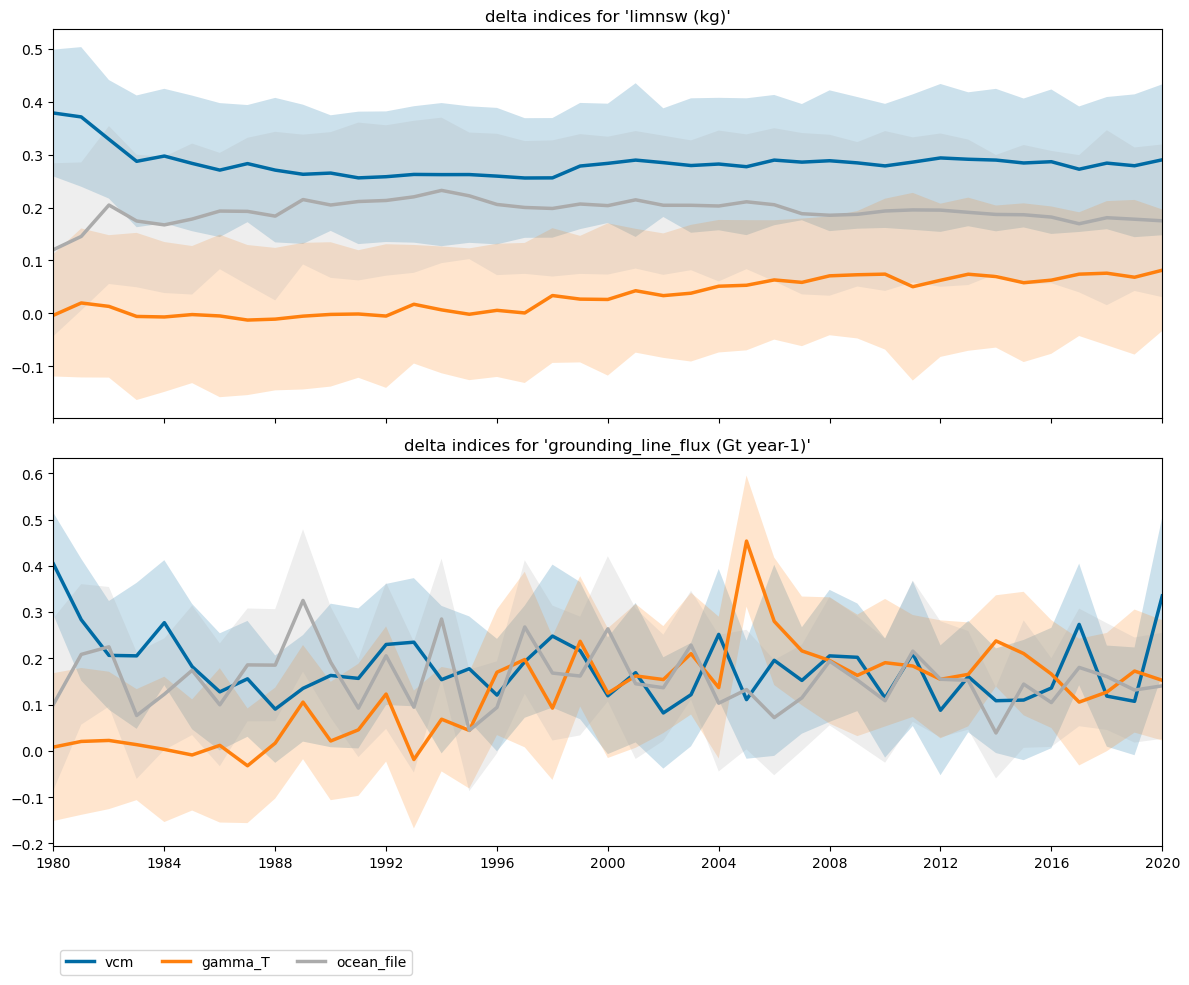

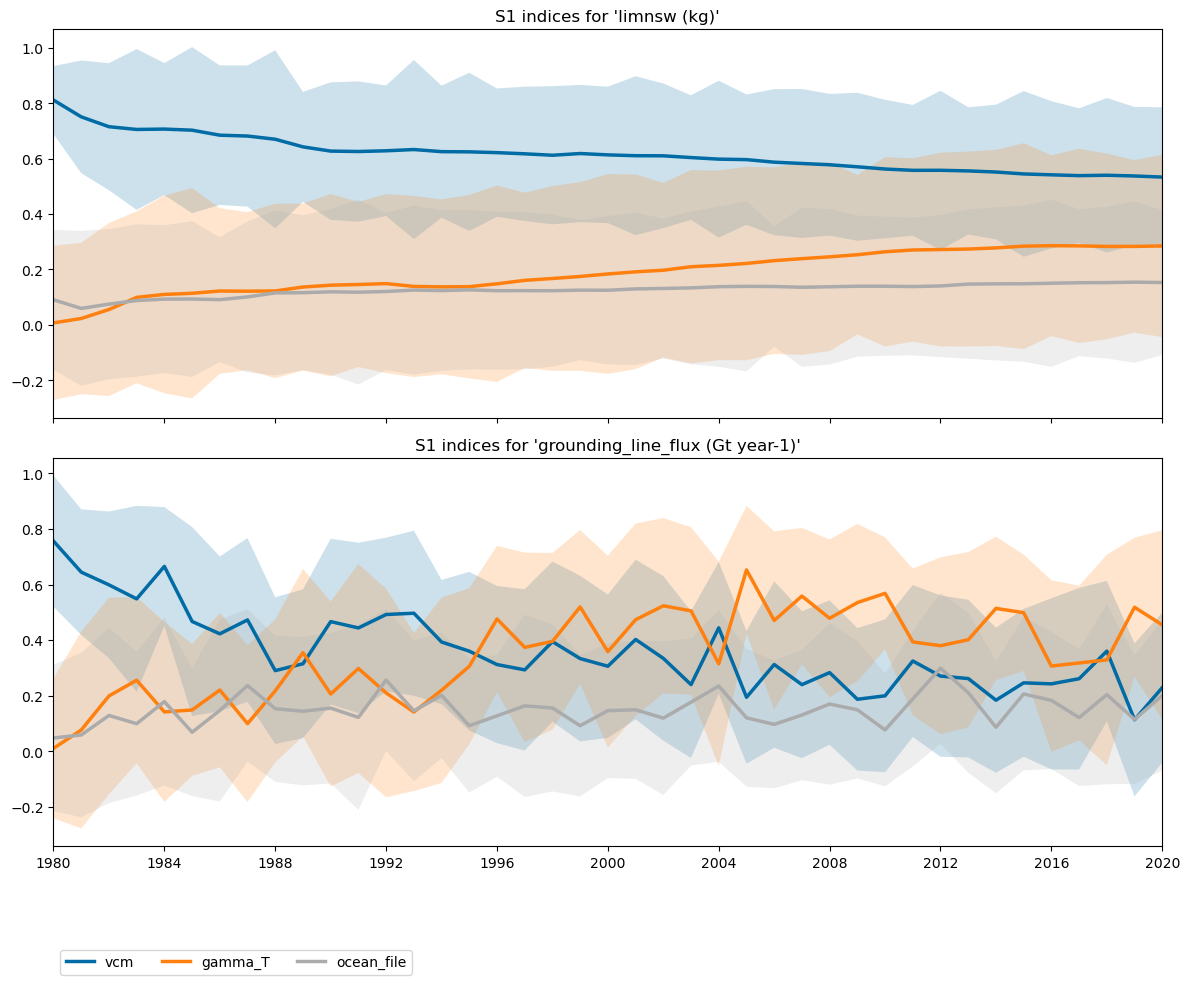

Processing 1983-01-01 00:00:00
Processing 1986-01-01 00:00:00
Processing 1991-01-01 00:00:00
Processing 1995-01-01 00:00:00
Processing 1997-01-01 00:00:00
Processing 2001-01-01 00:00:00
Processing 2006-01-01 00:00:00
Processing 2010-01-01 00:00:00
Processing 2014-01-01 00:00:00
Processing 2017-01-01 00:00:00
Processing 1981-01-01 00:00:00
Processing 1987-01-01 00:00:00
Processing 1990-01-01 00:00:00
Processing 1994-01-01 00:00:00
Processing 1999-01-01 00:00:00
Processing 2003-01-01 00:00:00
Processing 2007-01-01 00:00:00
Processing 2011-01-01 00:00:00
Processing 2015-01-01 00:00:00
Processing 2018-01-01 00:00:00
Processing 1980-01-01 00:00:00
Processing 1985-01-01 00:00:00
Processing 1989-01-01 00:00:00
Processing 1993-01-01 00:00:00
Processing 1998-01-01 00:00:00
Processing 2002-01-01 00:00:00
Processing 2005-01-01 00:00:00
Processing 2009-01-01 00:00:00
Processing 2013-01-01 00:00:00
Processing 2019-01-01 00:00:00
Processing 1982-01-01 00:00:00
Processing 1984-01-01 00:00:00
Processi

In [63]:
plt.style.use("tableau-colorblind10")

for si in ["delta", "S1"]:

    fig, axs = plt.subplots(
        2,
        1,
        sharex="col",
        figsize=[12, 10],
    )
    fig.subplots_adjust(bottom=0.0)
    for k, m_var in enumerate(["limnsw (kg)", "grounding_line_flux (Gt year-1)"]):
        m_df = sa_df[sa_df["Variable"] == m_var]
        ax = axs.ravel()[k]
        p_df = m_df[m_df["Si"] == si].drop(columns=["Si", "Variable"]).set_index("Date")
        p_conf_df = m_df[m_df["Si"] == si + "_conf"].drop(columns=["Si"])

        [
            ax.plot(p_df.index, p_df[v], lw=2.5, label=v)
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]

        [
            ax.fill_between(
                p_df.index,
                p_df[v].values - p_conf_df[v].values,
                p_df[v].values + p_conf_df[v].values,
                alpha=0.2,
                lw=0,
            )
            for v in sa_df.drop(columns=["Si", "Variable", "Date"]).keys()
        ]
        ax.set_xlim(datetime(1980, 1, 1), datetime(2020, 1, 1))
        lgd = ax.set_title(f"{si} indices for '{m_var}'")
    legend = axs[-1].legend(loc="lower left", ncols=3, bbox_to_anchor=(0, -0.35))
    fig.tight_layout()


In [11]:
import seaborn as sns

In [12]:
df["limnsw (kg)"] - df["limnsw (kg)"][]

SyntaxError: invalid syntax (3515375489.py, line 1)

/opt/local/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_core.py:1057: FutureWarning: reindexing with a non-unique Index is deprecated and will raise in a future version.
  comp_col.loc[orig.index] = pd.to_numeric(axis.convert_units(orig))


ValueError: cannot reindex on an axis with duplicate labels

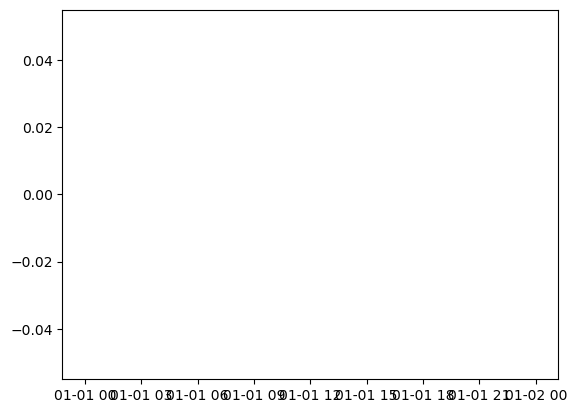

In [13]:
sns.lineplot(data=df, x="time", y="limnsw (kg)", hue="id", ci = None)

In [17]:
for id, ens in df.groupby(by="id"):
    print(ens)

         time  id  basal_mass_flux_floating (Gt year-1)  \
0  1980-01-01   0                           -708.612793   
1  1981-01-01   0                           -575.749830   
2  1982-01-01   0                           -439.475161   
3  1983-01-01   0                           -365.389104   
4  1984-01-01   0                           -366.645195   
5  1985-01-01   0                           -352.525731   
6  1986-01-01   0                           -341.249425   
7  1987-01-01   0                           -332.947283   
8  1988-01-01   0                           -315.085527   
9  1989-01-01   0                           -328.631991   
10 1990-01-01   0                           -324.020695   
11 1991-01-01   0                           -327.284922   
12 1992-01-01   0                           -311.445084   
13 1993-01-01   0                           -302.929764   
14 1994-01-01   0                           -302.895170   
15 1995-01-01   0                           -303.355314 